# Data Challenge - Advanced Machine Learning


**The data challenge is proposed by Idemia**

## Description of the data challenge

You have at your disposal 100000 images of human faces, and their occlusion label.
The goal of this challenge is to regress the percentage of the face that is occluded.
We also want to have similar performances on female and male, the gender label is given for the train database.

Below is the formula of the evaluation score. You'll first need to compute the error made by your model for men and women separetely. The error is measured as follows

$$
 Err = \frac{\sum_{i}{w_i(p_i - GT_i)^2}}{\sum_{i}{w_i}}, w_i = \frac{1}{30} + GT_i,
$$
where $GT_i$ is the ground truth and p_i the prediction made by your model. 

Then, the final score for the leaderboard is given by

$$
Score = \frac{Err_F + Err_M}{2} + \left | Err_F - Err_M \right |,
$$
where $Err_F$ and $Err_M$ are the errors obtained for female and men, respectively.

Hereafter we show you how to load the data and run a naive baseline using a pretrained model.

### Downloading the Data:

You can download the Dataset from the below links: https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax

In [113]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

In [114]:
import os

# Vérifier si le fichier existe
train_file_path = "Data/listes_training/data_100K/train_100K.csv"
test_file_path = "Data/listes_training/data_100K/test_students.csv"

if not os.path.exists(train_file_path):
    print(f"Le fichier {train_file_path} n'existe pas.")
else:
    print(f"Le fichier {train_file_path} existe.")

if not os.path.exists(test_file_path):
    print(f"Le fichier {test_file_path} n'existe pas.")
else:
    print(f"Le fichier {test_file_path} existe.")

Le fichier Data/listes_training/data_100K/train_100K.csv existe.
Le fichier Data/listes_training/data_100K/test_students.csv existe.


### Load dataframes

In [115]:
df_train = pd.read_csv("Data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("Data/listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "Data/crops_100K"

In [116]:
df_train.tail()

,filename,FaceOcclusion,gender
101340,database3/database3/m.01drbr/85-FaceId-0_align...,0.017,1.000
101341,database3/database3/m.01drbr/86-FaceId-0_align...,0.152,1.000
101342,database3/database3/m.01drbr/87-FaceId-0_align...,0.004,0.999
101343,database3/database3/m.01drbr/90-FaceId-0_align...,0.012,1.000
101344,database3/database3/m.01drbr/92-FaceId-0_align...,0.036,1.000


In [117]:
df_test.head()

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg


#### Remove nan values

In [118]:
df_train = df_train.dropna()
df_test = df_test.dropna()

### Split Dataframe in train and val

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 假设 df_train 已经加载

# 随机打乱数据集
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# 将数据集分割为训练集和验证集，80% 用于训练，20% 用于验证
df_train, df_val = train_test_split(df_train_shuffled, test_size=0.2, random_state=42)

# 重置索引
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# 查看结果
print("Training set:")
print(df_train.head())
print("\nValidation set:")
print(df_val.head())

Training set:
                                            filename  FaceOcclusion  gender
0                          database1/img00015966.jpg          0.015   0.997
1  database3/database3/m.01bczm/134-FaceId-0_alig...          0.011   0.998
2  database3/database3/m.01bldq/0-FaceId-0_align.jpg          0.071   0.997
3                          database1/img00017957.jpg          0.351   0.001
4                          database1/img00020727.jpg          0.128   0.001

Validation set:
                                            filename  FaceOcclusion  gender
0  database3/database3/m.01b1jr/84-FaceId-0_align...          0.061   1.000
1  database3/database3/m.018j3w/68-FaceId-0_align...          0.213   0.845
2  database3/database3/m.01bjs2/47-FaceId-0_align...          0.195   0.999
3                          database1/img00010973.jpg          0.015   0.999
4  database3/database3/m.01541z/61-FaceId-0_align...          0.108   0.001


In [120]:
len(df_train), len(df_val), len(df_test)

(81072, 20269, 30507)

<Axes: >

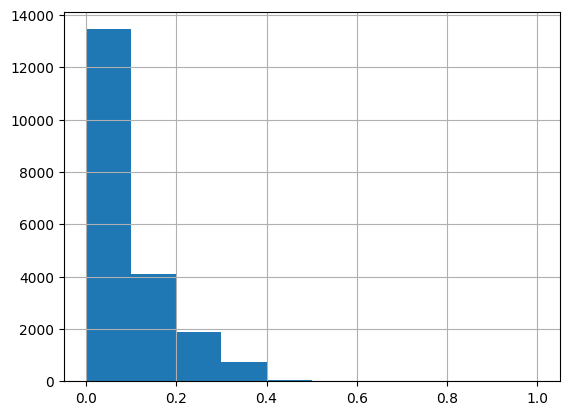

In [121]:
df_val['FaceOcclusion'].hist()

### Check that all images are read correctly

### Display first images

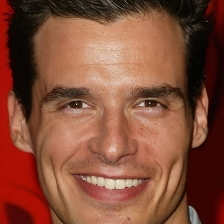

database1/img00015966.jpg 0.015 0.997


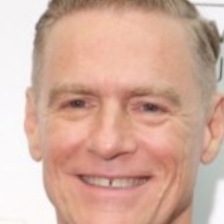

database3/database3/m.01bczm/134-FaceId-0_align.jpg 0.011 0.998


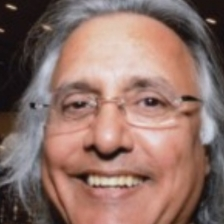

database3/database3/m.01bldq/0-FaceId-0_align.jpg 0.071 0.997


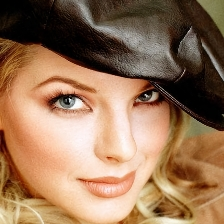

database1/img00017957.jpg 0.351 0.001


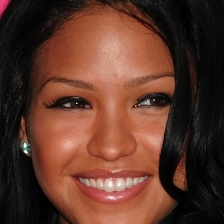

database1/img00020727.jpg 0.128 0.001


In [122]:
for idx, row in df_train[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

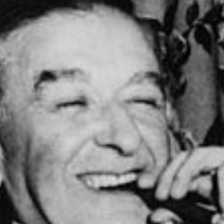

database3/database3/m.01b1jr/84-FaceId-0_align.jpg 0.061 1.0


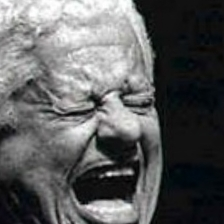

database3/database3/m.018j3w/68-FaceId-0_align.jpg 0.213 0.845


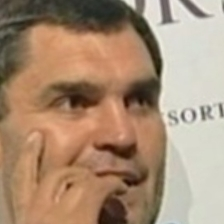

database3/database3/m.01bjs2/47-FaceId-0_align.jpg 0.195 0.999


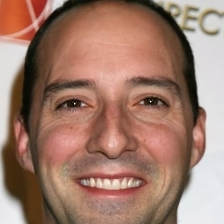

database1/img00010973.jpg 0.015 0.999


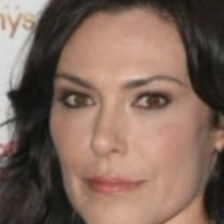

database3/database3/m.01541z/61-FaceId-0_align.jpg 0.108 0.001


In [123]:
for idx, row in df_val[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

### Make Dataset and Dataloader

In [124]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename

In [125]:
training_set = Dataset(df_train, image_dir)
validation_set = Dataset(df_val, image_dir)

params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

### Create naive model

In [126]:
'''
model = torchvision.models.mobilenet_v3_small(num_classes=1)
if torch.cuda.is_available():
    model.cuda()    
model
'''

'\nmodel = torchvision.models.mobilenet_v3_small(num_classes=1)\nif torch.cuda.is_available():\n    model.cuda()    \nmodel\n'

### Loss and optimizer

In [127]:
loss_fn = nn.MSELoss()

### Train naive model

In [128]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#### Fit on train split

In [129]:
# 定义覆盖率范围
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']


# 统计每个范围的样本数量
df_train['range'] = pd.cut(df_train['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train['range'].value_counts().sort_index()
print(range_counts)
range_means = df_train.groupby('range')['FaceOcclusion'].mean()
print(range_means)

# 计算权重
total_samples = len(df_train)
# range_weights = {label: (total_samples / count) * (1/30 + mean) for label, count, mean in zip(range_counts.index, range_counts.values, range_means.values)}


range_weights = {label: total_samples / count for label, count in range_counts.items()}
print(range_weights)

range
0-0.025       25704
0.025-0.05    13538
0.05-0.075     8316
0.075-0.1      6563
0.1-0.15      10066
0.15-0.2       6533
0.2-0.25       4285
0.25-0.3       3081
0.3-0.35       1869
>0.35          1117
Name: count, dtype: int64
range
0-0.025       0.011090
0.025-0.05    0.036709
0.05-0.075    0.062414
0.075-0.1     0.087556
0.1-0.15      0.123740
0.15-0.2      0.173677
0.2-0.25      0.223979
0.25-0.3      0.274255
0.3-0.35      0.322576
>0.35         0.396276
Name: FaceOcclusion, dtype: float64
{'0-0.025': 3.15406162464986, '0.025-0.05': 5.988476879893633, '0.05-0.075': 9.74891774891775, '0.075-0.1': 12.35288739905531, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}


C:\Users\Mita\AppData\Local\Temp\ipykernel_6736\1871310752.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_means = df_train.groupby('range')['FaceOcclusion'].mean()


In [130]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load pre-trained ResNet and modify it
# Load pre-trained ResNet and modify it for regression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()
    
    
# Define loss and optimizer
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y,range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


'''


# 加载预训练的EfficientNet
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# 修改最后的全连接层
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')
'''

C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


  0%|          | 1/10134 [00:00<25:52,  6.53it/s]

Batch 0, Loss: 5.516346454620361


  0%|          | 39/10134 [00:02<11:10, 15.06it/s]


KeyboardInterrupt: 

In [ ]:
'''
num_epochs = 5

for n in range(num_epochs):
    print(f"Epoch {n}")
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
'''

Epoch 0


  0%|          | 0/10168 [00:00<?, ?it/s]

  0%|          | 0/10168 [00:00<?, ?it/s]


NameError: name 'model' is not defined

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné ResNet et le modifier pour la régression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

# Définir la perte et l'optimiseur
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 8
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')

# Bloc de code commenté pour un autre modèle, par exemple EfficientNet
'''
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')
'''


Epoch 1/8


  0%|          | 1/10134 [00:00<21:57,  7.69it/s]

Batch 0, Loss: 1.6838661432266235


 20%|█▉        | 2004/10134 [02:20<08:38, 15.67it/s]

Batch 2000, Loss: 0.04141131043434143


 40%|███▉      | 4004/10134 [04:41<07:03, 14.46it/s]

Batch 4000, Loss: 0.05761095881462097


 59%|█████▉    | 6002/10134 [07:02<04:52, 14.12it/s]

Batch 6000, Loss: 0.007146784104406834


 79%|███████▉  | 8002/10134 [09:37<02:41, 13.24it/s]

Batch 8000, Loss: 0.02590208314359188


 99%|█████████▊| 10002/10134 [12:27<00:11, 11.15it/s]

Batch 10000, Loss: 0.015352929010987282


100%|██████████| 10134/10134 [12:40<00:00, 13.32it/s]


Epoch [1/8], Loss: 0.08417772551916497
Epoch 2/8


  0%|          | 1/10134 [00:00<16:57,  9.96it/s]

Batch 0, Loss: 0.012465289793908596


 20%|█▉        | 2001/10134 [03:07<13:37,  9.95it/s]

Batch 2000, Loss: 0.04772662743926048


 39%|███▉      | 4001/10134 [05:59<09:58, 10.25it/s]

Batch 4000, Loss: 0.00448035029694438


 42%|████▏     | 4290/10134 [06:27<08:47, 11.07it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné ResNet et le modifier pour la régression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

# Assurez-vous que range_weights est défini
range_weights = {
    '0': 1.0,
    '1': 0.5,
    '2': 0.2,
    # Ajoutez d'autres poids en fonction de vos classes de données
}

# Définir la perte et l'optimiseur
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fonction pour sauvegarder le modèle et l'optimiseur
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# Fonction pour charger le modèle et l'optimiseur
def load_checkpoint(filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from epoch {epoch+1}")
    return epoch, loss

# Charger le point de contrôle si disponible
try:
    start_epoch, _ = load_checkpoint()
except FileNotFoundError:
    start_epoch = 0

num_epochs = 3
for epoch in range(start_epoch, start_epoch + num_epochs):
    print(f"Epoch {epoch+1}/{start_epoch + num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Loss: {running_loss/len(training_generator)}")

    # Sauvegarder le point de contrôle à la fin de chaque époque
    save_checkpoint(epoch, model, optimizer, running_loss)

print('Training complete')

# Bloc de code commenté pour un autre modèle, par exemple EfficientNet
'''
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')
'''


Epoch 1/3


  0%|          | 2/10134 [00:00<37:38,  4.49it/s]  

Batch 0, Loss: 0.1384488046169281


 20%|█▉        | 2003/10134 [02:49<10:52, 12.47it/s]

Batch 2000, Loss: 0.0007903422228991985


 40%|███▉      | 4003/10134 [05:36<08:49, 11.57it/s]

Batch 4000, Loss: 0.0007868142565712333


 59%|█████▉    | 6003/10134 [08:28<05:14, 13.14it/s]

Batch 6000, Loss: 0.0007302460144273937


 79%|███████▉  | 8002/10134 [11:13<02:48, 12.63it/s]

Batch 8000, Loss: 0.000599672319367528


 99%|█████████▊| 10002/10134 [13:55<00:11, 11.96it/s]

Batch 10000, Loss: 0.0009488111827522516


100%|██████████| 10134/10134 [14:06<00:00, 11.98it/s]


Epoch [1/3], Loss: 0.0022895762261743585
Checkpoint saved at epoch 1
Epoch 2/3


  0%|          | 1/10134 [00:00<17:54,  9.43it/s]

Batch 0, Loss: 0.0008539312402717769


 20%|█▉        | 2003/10134 [02:50<11:15, 12.03it/s]

Batch 2000, Loss: 0.00011405932309571654


 40%|███▉      | 4003/10134 [05:42<08:17, 12.32it/s]

Batch 4000, Loss: 0.00016900528862606734


 59%|█████▉    | 6002/10134 [08:30<05:26, 12.66it/s]

Batch 6000, Loss: 0.00040855654515326023


 79%|███████▉  | 8002/10134 [11:15<02:48, 12.67it/s]

Batch 8000, Loss: 0.00163658382371068


 99%|█████████▊| 10002/10134 [13:53<00:10, 12.80it/s]

Batch 10000, Loss: 0.00022055840236134827


100%|██████████| 10134/10134 [14:04<00:00, 12.00it/s]


Epoch [2/3], Loss: 0.0006515664966953681
Checkpoint saved at epoch 2
Epoch 3/3


  0%|          | 1/10134 [00:00<19:43,  8.56it/s]

Batch 0, Loss: 0.000499865273013711


 20%|█▉        | 2002/10134 [02:46<10:14, 13.24it/s]

Batch 2000, Loss: 0.00044576491927728057


 39%|███▉      | 4002/10134 [05:23<07:39, 13.34it/s]

Batch 4000, Loss: 0.0002796014305204153


 59%|█████▉    | 6002/10134 [08:00<04:54, 14.05it/s]

Batch 6000, Loss: 0.00016966059047263116


 79%|███████▉  | 8002/10134 [10:35<02:38, 13.44it/s]

Batch 8000, Loss: 0.0018502166494727135


 99%|█████████▊| 10002/10134 [13:15<00:09, 13.66it/s]

Batch 10000, Loss: 0.0005539330886676908


100%|██████████| 10134/10134 [13:25<00:00, 12.58it/s]


Epoch [3/3], Loss: 0.0004972610086135887
Checkpoint saved at epoch 3
Training complete


'\nmodel = models.efficientnet_b0(pretrained=True)\nif torch.cuda.is_available():\n    model.cuda()\n    \nnum_features = model.classifier[1].in_features\nmodel.classifier[1] = nn.Linear(num_features, 1)\nmodel = model.to(device)\n\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\n\nnum_epochs = 10\nfor epoch in range(num_epochs):\n    print(f"Epoch {epoch+1}/{num_epochs}")\n    model.train()\n    running_loss = 0.0\n    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):\n        X, y = X.to(device), y.to(device).view(-1, 1)\n        optimizer.zero_grad()\n        y_pred = model(X)\n        loss = criterion(y_pred, y)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n        if batch_idx % 2000 == 0:\n            print(f"Batch {batch_idx}, Loss: {loss.item()}")\n\n    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")\n\n

## Evaluate metric on validation split

In [ ]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print(err_male)
    print(err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [ ]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

  0%|          | 0/2534 [00:00<?, ?it/s]

100%|██████████| 2534/2534 [01:47<00:00, 23.63it/s]


In [ ]:
results_df.head()

,pred,target,gender
0,0.142421,0.061,1.000
1,0.053964,0.213,0.845
2,0.119121,0.195,0.999
3,0.008635,0.015,0.999
4,0.101703,0.108,0.001


<Axes: >

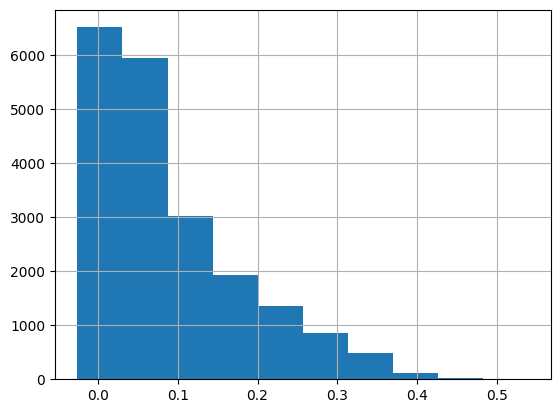

In [ ]:
results_df['pred'].hist()

  0%|          | 0/2534 [00:00<?, ?it/s]

100%|██████████| 2534/2534 [02:20<00:00, 17.99it/s]


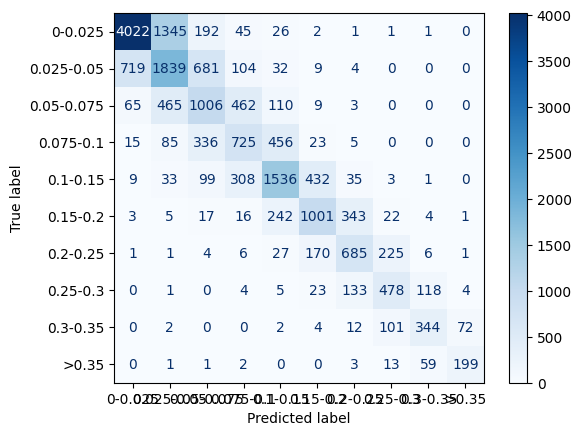

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()




In [ ]:
print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.83      0.64      0.72      6288
  0.025-0.05       0.49      0.54      0.51      3396
  0.05-0.075       0.43      0.47      0.45      2122
   0.075-0.1       0.43      0.44      0.44      1646
    0.1-0.15       0.63      0.63      0.63      2456
    0.15-0.2       0.60      0.61      0.60      1654
    0.2-0.25       0.56      0.61      0.58      1126
    0.25-0.3       0.57      0.62      0.59       766
    0.3-0.35       0.65      0.64      0.64       537
       >0.35       0.72      0.72      0.72       278

   micro avg       0.60      0.58      0.59     20269
   macro avg       0.59      0.59      0.59     20269
weighted avg       0.62      0.58      0.60     20269



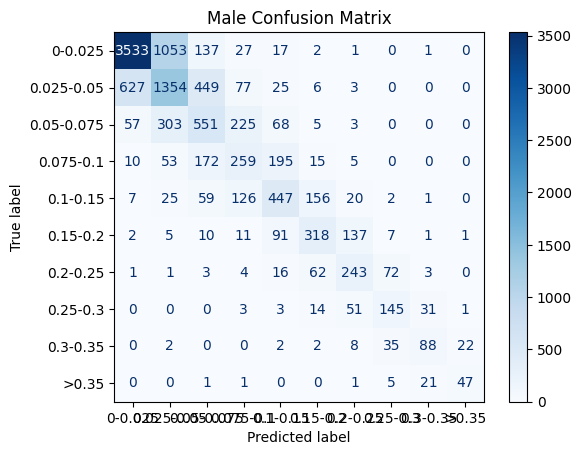

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.83      0.66      0.73      5384
  0.025-0.05       0.48      0.53      0.51      2549
  0.05-0.075       0.40      0.45      0.42      1214
   0.075-0.1       0.35      0.36      0.36       710
    0.1-0.15       0.52      0.53      0.52       843
    0.15-0.2       0.55      0.55      0.55       583
    0.2-0.25       0.51      0.60      0.55       405
    0.25-0.3       0.55      0.58      0.56       248
    0.3-0.35       0.60      0.55      0.58       159
       >0.35       0.66      0.62      0.64        76

   micro avg       0.60      0.57      0.59     12171
   macro avg       0.55      0.54      0.54     12171
weighted avg       0.63      0.57      0.60     12171



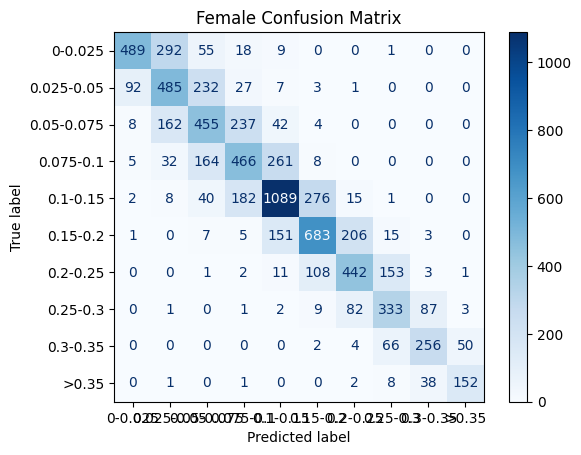

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.82      0.54      0.65       904
  0.025-0.05       0.49      0.57      0.53       847
  0.05-0.075       0.48      0.50      0.49       908
   0.075-0.1       0.50      0.50      0.50       936
    0.1-0.15       0.69      0.68      0.68      1613
    0.15-0.2       0.62      0.64      0.63      1071
    0.2-0.25       0.59      0.61      0.60       721
    0.25-0.3       0.58      0.64      0.61       518
    0.3-0.35       0.66      0.68      0.67       378
       >0.35       0.74      0.75      0.75       202

   micro avg       0.60      0.60      0.60      8098
   macro avg       0.62      0.61      0.61      8098
weighted avg       0.61      0.60      0.60      8098



In [ ]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # 显示混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# 绘制男性混淆矩阵
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# 绘制女性混淆矩阵
plot_confusion_matrix(results_female, "Female Confusion Matrix")

In [ ]:
metric_fn(results_male, results_female)

0.0012915440527293564
0.0011094393973412652


0.001382596380423402

## Evaluating your Test DataSet

In [ ]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [ ]:
### face mesh

'''
class faceDataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        

        return X, filename

'''

'\nclass faceDataset_test(torch.utils.data.Dataset):\n    \'Characterizes a dataset for PyTorch\'\n    def __init__(self, df, image_dir):\n         \'Initialization\'\n         self.image_dir = image_dir\n         self.df = df\n         self.transform = transforms.ToTensor()\n         \n    def __len__(self):\n        \'Denotes the total number of samples\'\n        return len(self.df)\n\n    def __getitem__(self, index):\n        \'Generates one sample of data\'\n        # Select sample\n        row = self.df.loc[index]\n        filename = row[\'filename\']\n\n        img_path = f"{self.image_dir}/{filename}"\n        img = cv2.imread(img_path)\n        landmarks = get_face_landmarks(img)\n        \n        if landmarks:\n            X = torch.tensor(landmarks).view(-1)\n        else:\n            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标\n        \n\n        return X, filename\n\n'

In [ ]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [ ]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [02:23<00:00, 26.58it/s]


In [ ]:
test_df.head()

,pred
0,0.374279
1,0.331915
2,0.260264
3,0.294750
4,0.391154


### Preparing your file for Submission

In [ ]:
test_df.to_csv("Data_Challenge_1.csv", header = None, index = None)

#### Now it's your turn. Good luck !  :) 

# Epoch 06

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné ResNet et le modifier pour la régression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

# Définir la perte et l'optimiseur
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fonction pour sauvegarder le modèle et l'optimiseur
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# Fonction pour charger le modèle et l'optimiseur
def load_checkpoint(filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from epoch {epoch+1}")
    return epoch, loss

# Charger le point de contrôle si disponible
try:
    start_epoch, _ = load_checkpoint()
except FileNotFoundError:
    start_epoch = 0

# Définir le nombre total d'époques que vous souhaitez atteindre
total_epochs = 6

# Calculer le nombre d'époques restantes
remaining_epochs = total_epochs - start_epoch

for epoch in range(start_epoch, start_epoch + remaining_epochs):
    if epoch == start_epoch:
        continue  # Skip the epoch 3 if already completed
    
    print(f"Epoch {epoch+1}/{total_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {running_loss/len(training_generator)}")

    # Sauvegarder le point de contrôle à la fin de chaque époque
    save_checkpoint(epoch, model, optimizer, running_loss)

print('Training complete')


Checkpoint loaded from epoch 6
Training complete


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné ResNet et le modifier pour la régression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

# Définir la perte et l'optimiseur
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fonction pour sauvegarder le modèle et l'optimiseur
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# Définir le nombre total d'époques que vous souhaitez atteindre
total_epochs = 6

for epoch in range(total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {running_loss/len(training_generator)}")

    # Sauvegarder le point de contrôle à la fin de chaque époque
    save_checkpoint(epoch, model, optimizer, running_loss, filename=f'checkpoint_epoch_{epoch+1}.pth')

print('Training complete')


Epoch 1/6


  0%|          | 1/12669 [00:00<26:35,  7.94it/s]

Batch 0, Loss: 0.07933411002159119


 16%|█▌        | 2003/12669 [02:26<12:58, 13.71it/s]

Batch 2000, Loss: nan


 32%|███▏      | 4002/12669 [05:14<10:29, 13.76it/s]  

Batch 4000, Loss: nan


 47%|████▋     | 6003/12669 [07:53<08:28, 13.12it/s]

Batch 6000, Loss: nan


 58%|█████▊    | 7338/12669 [09:40<07:01, 12.64it/s]


KeyboardInterrupt: 

## Evaluate metric on validation split

In [ ]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print(err_male)
    print(err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [ ]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

  0%|          | 0/2534 [00:00<?, ?it/s]

100%|██████████| 2534/2534 [01:59<00:00, 21.29it/s]


In [ ]:
results_df.head()

,pred,target,gender
0,0.089745,0.061,1.000
1,0.078745,0.213,0.845
2,0.106008,0.195,0.999
3,0.003729,0.015,0.999
4,0.080728,0.108,0.001


<Axes: >

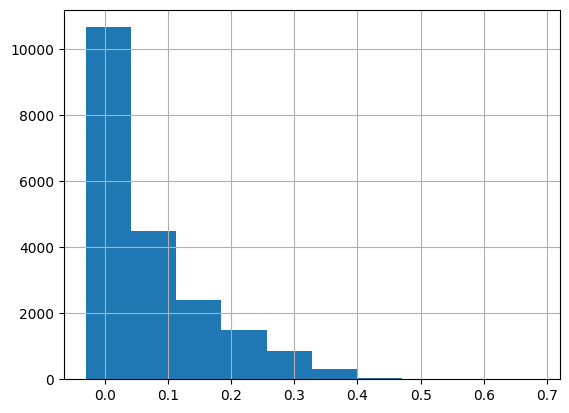

In [ ]:
results_df['pred'].hist()

100%|██████████| 2534/2534 [02:54<00:00, 14.53it/s]


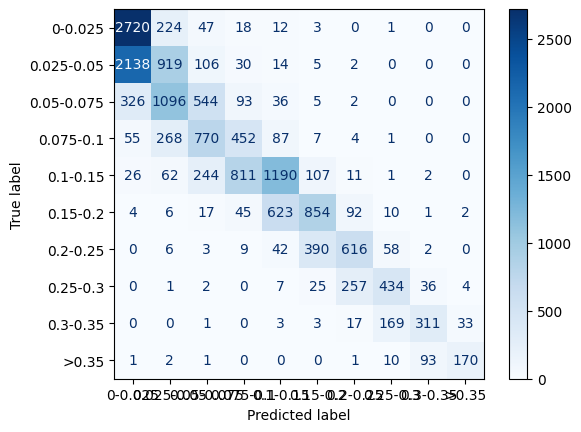

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()




In [ ]:
print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.52      0.43      0.47      6288
  0.025-0.05       0.36      0.27      0.31      3396
  0.05-0.075       0.31      0.26      0.28      2122
   0.075-0.1       0.31      0.27      0.29      1646
    0.1-0.15       0.59      0.48      0.53      2456
    0.15-0.2       0.61      0.52      0.56      1654
    0.2-0.25       0.61      0.55      0.58      1126
    0.25-0.3       0.63      0.57      0.60       766
    0.3-0.35       0.70      0.58      0.63       537
       >0.35       0.81      0.61      0.70       278

   micro avg       0.49      0.41      0.44     20269
   macro avg       0.55      0.45      0.50     20269
weighted avg       0.49      0.41      0.44     20269



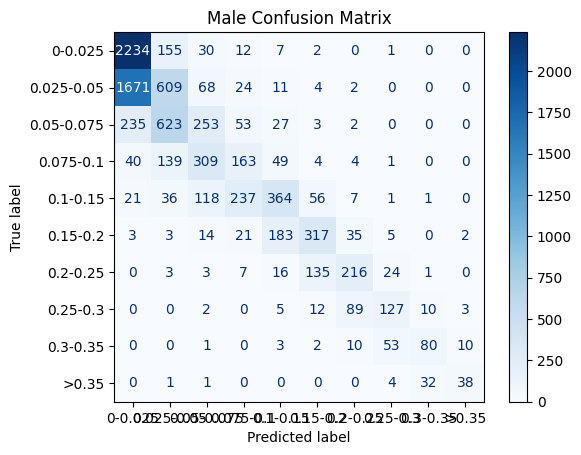

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.53      0.41      0.47      5384
  0.025-0.05       0.39      0.24      0.30      2549
  0.05-0.075       0.32      0.21      0.25      1214
   0.075-0.1       0.32      0.23      0.27       710
    0.1-0.15       0.55      0.43      0.48       843
    0.15-0.2       0.59      0.54      0.57       583
    0.2-0.25       0.59      0.53      0.56       405
    0.25-0.3       0.59      0.51      0.55       248
    0.3-0.35       0.65      0.50      0.57       159
       >0.35       0.72      0.50      0.59        76

   micro avg       0.49      0.36      0.41     12171
   macro avg       0.52      0.41      0.46     12171
weighted avg       0.48      0.36      0.41     12171



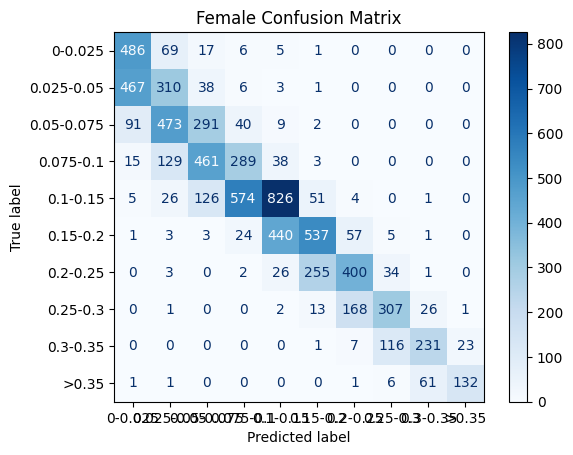

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.46      0.54      0.49       904
  0.025-0.05       0.31      0.37      0.33       847
  0.05-0.075       0.31      0.32      0.32       908
   0.075-0.1       0.31      0.31      0.31       936
    0.1-0.15       0.61      0.51      0.56      1613
    0.15-0.2       0.62      0.50      0.56      1071
    0.2-0.25       0.63      0.55      0.59       721
    0.25-0.3       0.66      0.59      0.62       518
    0.3-0.35       0.72      0.61      0.66       378
       >0.35       0.85      0.65      0.74       202

   micro avg       0.49      0.47      0.48      8098
   macro avg       0.55      0.50      0.52      8098
weighted avg       0.51      0.47      0.49      8098



In [ ]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # 显示混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# 绘制男性混淆矩阵
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# 绘制女性混淆矩阵
plot_confusion_matrix(results_female, "Female Confusion Matrix")

In [ ]:
metric_fn(results_male, results_female)

0.001353202038093008
0.001255952986715969


0.0014018265637815277

## Evaluating your Test DataSet

In [ ]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [ ]:
### face mesh

'''
class faceDataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        

        return X, filename

'''

'\nclass faceDataset_test(torch.utils.data.Dataset):\n    \'Characterizes a dataset for PyTorch\'\n    def __init__(self, df, image_dir):\n         \'Initialization\'\n         self.image_dir = image_dir\n         self.df = df\n         self.transform = transforms.ToTensor()\n         \n    def __len__(self):\n        \'Denotes the total number of samples\'\n        return len(self.df)\n\n    def __getitem__(self, index):\n        \'Generates one sample of data\'\n        # Select sample\n        row = self.df.loc[index]\n        filename = row[\'filename\']\n\n        img_path = f"{self.image_dir}/{filename}"\n        img = cv2.imread(img_path)\n        landmarks = get_face_landmarks(img)\n        \n        if landmarks:\n            X = torch.tensor(landmarks).view(-1)\n        else:\n            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标\n        \n\n        return X, filename\n\n'

In [ ]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [ ]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [02:47<00:00, 22.73it/s]


In [ ]:
test_df.head()

,pred
0,0.309079
1,0.381690
2,0.372861
3,0.278003
4,0.400269


### Preparing your file for Submission

In [ ]:
test_df.to_csv("Data_Challenge_2.csv", header = None, index = None)

In [ ]:
# Epoch 1 à 6

In [153]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné ResNet et le modifier pour la régression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

# Définir la perte et l'optimiseur
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fonction pour sauvegarder le modèle et l'optimiseur
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# Définir le nombre total d'époques que vous souhaitez atteindre
total_epochs = 6

for epoch in range(total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {running_loss/len(training_generator)}")

    # Sauvegarder le point de contrôle à la fin de chaque époque
    save_checkpoint(epoch, model, optimizer, running_loss, filename=f'checkpoint_epoch_{epoch+1}.pth')

print('Training complete')


Epoch 1/6


  0%|          | 2/10134 [00:00<11:51, 14.24it/s]

Batch 0, Loss: 1.7242851257324219


 20%|█▉        | 2004/10134 [02:18<07:54, 17.13it/s]

Batch 2000, Loss: 0.05639652535319328


 40%|███▉      | 4003/10134 [04:46<06:32, 15.63it/s]

Batch 4000, Loss: 0.20726457238197327


 59%|█████▉    | 6001/10134 [07:21<05:47, 11.89it/s]

Batch 6000, Loss: 0.018020210787653923


 79%|███████▉  | 8003/10134 [10:21<02:38, 13.46it/s]

Batch 8000, Loss: 0.004573393613100052


 99%|█████████▊| 10003/10134 [12:54<00:10, 12.16it/s]

Batch 10000, Loss: 0.043930888175964355


100%|██████████| 10134/10134 [13:04<00:00, 12.92it/s]


Epoch [1/6], Loss: 0.08421564235753518
Checkpoint saved at epoch 1
Epoch 2/6


  0%|          | 2/10134 [00:00<13:19, 12.68it/s]

Batch 0, Loss: 0.011645101010799408


 20%|█▉        | 2004/10134 [02:39<09:07, 14.84it/s]

Batch 2000, Loss: 0.014564967714250088


 39%|███▉      | 4002/10134 [05:13<09:49, 10.41it/s]

Batch 4000, Loss: 0.028626758605241776


 59%|█████▉    | 6002/10134 [08:01<05:45, 11.95it/s]

Batch 6000, Loss: 0.012862415984272957


 79%|███████▉  | 8003/10134 [10:45<02:43, 13.07it/s]

Batch 8000, Loss: 0.013409780338406563


 99%|█████████▊| 10003/10134 [13:33<00:08, 14.58it/s]

Batch 10000, Loss: 0.00999592337757349


100%|██████████| 10134/10134 [13:44<00:00, 12.29it/s]


Epoch [2/6], Loss: 0.023572853561942695
Checkpoint saved at epoch 2
Epoch 3/6


  0%|          | 2/10134 [00:00<12:38, 13.35it/s]

Batch 0, Loss: 0.007025836501270533


 20%|█▉        | 2003/10134 [02:49<10:57, 12.37it/s]

Batch 2000, Loss: 0.01050016563385725


 39%|███▉      | 4002/10134 [05:36<11:53,  8.60it/s]

Batch 4000, Loss: 0.024028349667787552


 59%|█████▉    | 6001/10134 [08:19<07:47,  8.83it/s]

Batch 6000, Loss: 0.006701426114886999


 79%|███████▉  | 8003/10134 [10:59<03:08, 11.31it/s]

Batch 8000, Loss: 0.013586604967713356


 99%|█████████▊| 10003/10134 [13:36<00:10, 12.17it/s]

Batch 10000, Loss: 0.020518189296126366


100%|██████████| 10134/10134 [13:46<00:00, 12.26it/s]


Epoch [3/6], Loss: 0.01765784170920545
Checkpoint saved at epoch 3
Epoch 4/6


  0%|          | 2/10134 [00:00<17:02,  9.91it/s]

Batch 0, Loss: 0.01881328597664833


 20%|█▉        | 2002/10134 [02:41<11:34, 11.70it/s]

Batch 2000, Loss: 0.008112261071801186


 39%|███▉      | 4002/10134 [05:31<07:26, 13.72it/s]

Batch 4000, Loss: 0.0053671556524932384


 59%|█████▉    | 6002/10134 [08:15<05:32, 12.41it/s]

Batch 6000, Loss: 0.010579331777989864


 79%|███████▉  | 8002/10134 [10:54<02:45, 12.92it/s]

Batch 8000, Loss: 0.012504971586167812


 99%|█████████▊| 10002/10134 [13:46<00:10, 12.09it/s]

Batch 10000, Loss: 0.008632686920464039


100%|██████████| 10134/10134 [13:57<00:00, 12.09it/s]


Epoch [4/6], Loss: 0.014275180524395423
Checkpoint saved at epoch 4
Epoch 5/6


  0%|          | 2/10134 [00:00<12:54, 13.09it/s]

Batch 0, Loss: 0.012094149366021156


 20%|█▉        | 2003/10134 [02:39<10:20, 13.09it/s]

Batch 2000, Loss: 0.08895903825759888


 40%|███▉      | 4003/10134 [05:22<08:37, 11.86it/s]

Batch 4000, Loss: 0.005163621157407761


 59%|█████▉    | 6003/10134 [08:15<05:49, 11.80it/s]

Batch 6000, Loss: 0.008167519234120846


 79%|███████▉  | 8002/10134 [11:05<03:31, 10.10it/s]

Batch 8000, Loss: 0.00991626363247633


 99%|█████████▊| 10001/10134 [13:48<00:13,  9.78it/s]

Batch 10000, Loss: 0.0035878736525774


100%|██████████| 10134/10134 [13:58<00:00, 12.08it/s]


Epoch [5/6], Loss: 0.012094095979868975
Checkpoint saved at epoch 5
Epoch 6/6


  0%|          | 3/10134 [00:00<17:37,  9.58it/s]

Batch 0, Loss: 0.005934713874012232


 20%|█▉        | 2003/10134 [02:45<09:32, 14.19it/s]

Batch 2000, Loss: 0.0044376440346241


 40%|███▉      | 4003/10134 [05:20<08:08, 12.55it/s]

Batch 4000, Loss: 0.07829439640045166


 59%|█████▉    | 6003/10134 [07:54<04:54, 14.02it/s]

Batch 6000, Loss: 0.016397764906287193


 79%|███████▉  | 8003/10134 [10:28<02:35, 13.75it/s]

Batch 8000, Loss: 0.006623321212828159


 99%|█████████▊| 10003/10134 [13:03<00:09, 13.59it/s]

Batch 10000, Loss: 0.007830547168850899


100%|██████████| 10134/10134 [13:13<00:00, 12.77it/s]


Epoch [6/6], Loss: 0.010122624817636362
Checkpoint saved at epoch 6
Training complete


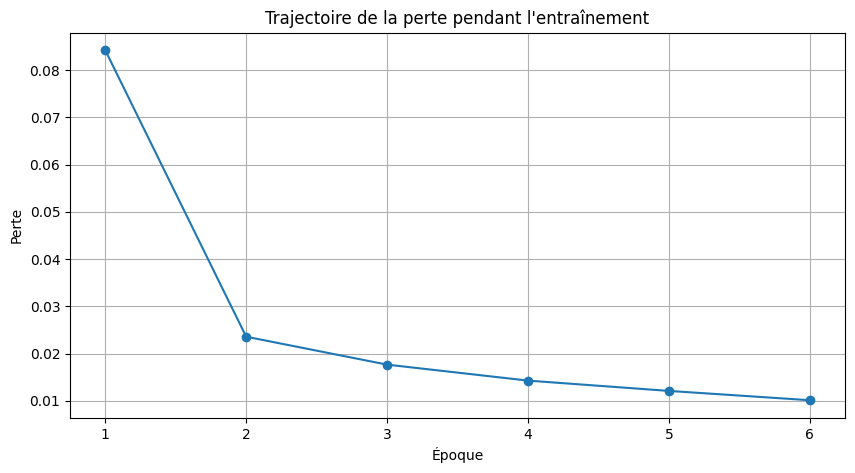

In [154]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Fonction pour charger les pertes depuis les checkpoints
def load_losses_from_checkpoints(num_epochs, checkpoint_path_template='checkpoint_epoch_{}.pth'):
    losses = []
    for epoch in range(1, num_epochs + 1):
        checkpoint = torch.load(checkpoint_path_template.format(epoch))
        losses.append(checkpoint['loss'] / len(training_generator))  # Normaliser la perte
    return losses

# Nombre total d'époques
total_epochs = 6

# Charger les pertes depuis les checkpoints
train_losses = load_losses_from_checkpoints(total_epochs)

# Visualiser la trajectoire de la perte
plt.figure(figsize=(10, 5))
plt.plot(range(1, total_epochs + 1), train_losses, marker='o')
plt.title('Trajectoire de la perte pendant l\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.grid(True)
plt.show()

# Sauvegarder les pertes dans un fichier CSV (optionnel)
loss_df = pd.DataFrame({'epoch': range(1, total_epochs + 1), 'loss': train_losses})
loss_df.to_csv('training_losses.csv', index=False)



## Evaluate metric on validation split

In [155]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print(err_male)
    print(err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [156]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

100%|██████████| 2534/2534 [01:51<00:00, 22.78it/s]


In [157]:
results_df.head()

,pred,target,gender
0,0.125624,0.061,1.000
1,0.100834,0.213,0.845
2,0.100149,0.195,0.999
3,0.028923,0.015,0.999
4,0.120117,0.108,0.001


<Axes: >

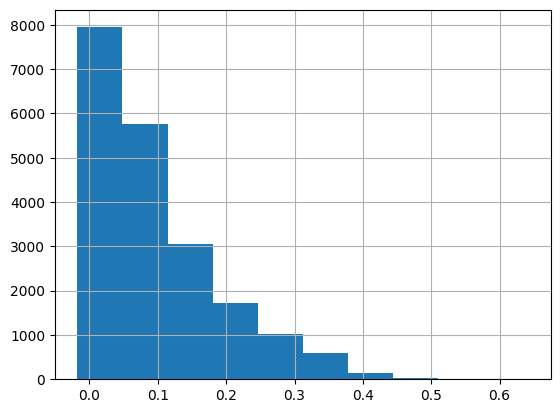

In [158]:
results_df['pred'].hist()

100%|██████████| 2534/2534 [02:42<00:00, 15.58it/s]


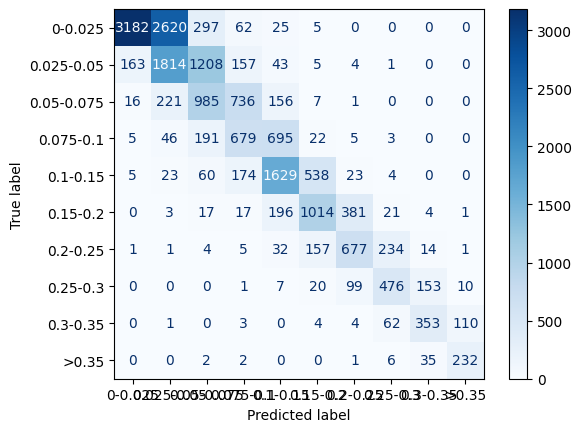

In [159]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()



In [160]:
print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.94      0.51      0.66      6288
  0.025-0.05       0.38      0.53      0.45      3396
  0.05-0.075       0.36      0.46      0.40      2122
   0.075-0.1       0.37      0.41      0.39      1646
    0.1-0.15       0.59      0.66      0.62      2456
    0.15-0.2       0.57      0.61      0.59      1654
    0.2-0.25       0.57      0.60      0.58      1126
    0.25-0.3       0.59      0.62      0.61       766
    0.3-0.35       0.63      0.66      0.64       537
       >0.35       0.66      0.83      0.73       278

   micro avg       0.55      0.54      0.55     20269
   macro avg       0.57      0.59      0.57     20269
weighted avg       0.62      0.54      0.56     20269



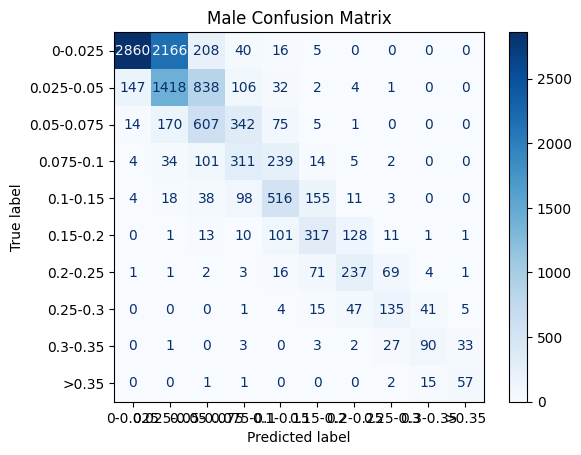

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.94      0.53      0.68      5384
  0.025-0.05       0.37      0.56      0.45      2549
  0.05-0.075       0.34      0.50      0.40      1214
   0.075-0.1       0.34      0.44      0.38       710
    0.1-0.15       0.52      0.61      0.56       843
    0.15-0.2       0.54      0.54      0.54       583
    0.2-0.25       0.54      0.59      0.56       405
    0.25-0.3       0.54      0.54      0.54       248
    0.3-0.35       0.60      0.57      0.58       159
       >0.35       0.59      0.75      0.66        76

   micro avg       0.54      0.54      0.54     12171
   macro avg       0.53      0.56      0.54     12171
weighted avg       0.65      0.54      0.56     12171



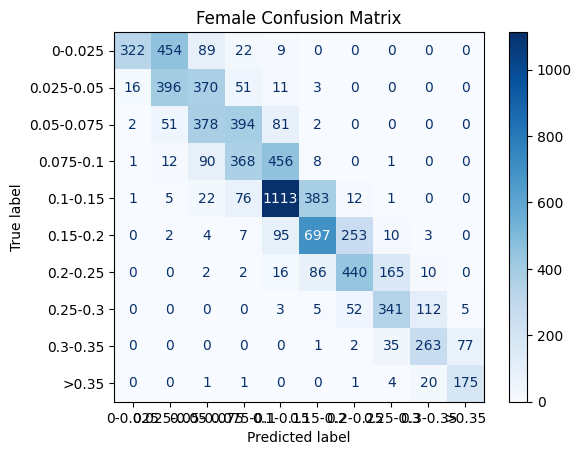

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.94      0.36      0.52       904
  0.025-0.05       0.43      0.47      0.45       847
  0.05-0.075       0.40      0.42      0.41       908
   0.075-0.1       0.40      0.39      0.40       936
    0.1-0.15       0.62      0.69      0.66      1613
    0.15-0.2       0.59      0.65      0.62      1071
    0.2-0.25       0.58      0.61      0.59       721
    0.25-0.3       0.61      0.66      0.63       518
    0.3-0.35       0.64      0.70      0.67       378
       >0.35       0.68      0.87      0.76       202

   micro avg       0.56      0.55      0.56      8098
   macro avg       0.59      0.58      0.57      8098
weighted avg       0.58      0.55      0.55      8098



In [161]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # 显示混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# 绘制男性混淆矩阵
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# 绘制女性混淆矩阵
plot_confusion_matrix(results_female, "Female Confusion Matrix")

In [162]:
metric_fn(results_male, results_female)

0.0011571884507592194
0.0010389547572743855


0.0012163052975016364

## Evaluating your Test DataSet

In [163]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [ ]:
### face mesh

'''
class faceDataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        

        return X, filename

'''

'\nclass faceDataset_test(torch.utils.data.Dataset):\n    \'Characterizes a dataset for PyTorch\'\n    def __init__(self, df, image_dir):\n         \'Initialization\'\n         self.image_dir = image_dir\n         self.df = df\n         self.transform = transforms.ToTensor()\n         \n    def __len__(self):\n        \'Denotes the total number of samples\'\n        return len(self.df)\n\n    def __getitem__(self, index):\n        \'Generates one sample of data\'\n        # Select sample\n        row = self.df.loc[index]\n        filename = row[\'filename\']\n\n        img_path = f"{self.image_dir}/{filename}"\n        img = cv2.imread(img_path)\n        landmarks = get_face_landmarks(img)\n        \n        if landmarks:\n            X = torch.tensor(landmarks).view(-1)\n        else:\n            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标\n        \n\n        return X, filename\n\n'

In [164]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [165]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [02:34<00:00, 24.64it/s]


In [166]:
test_df.head()

,pred
0,0.296334
1,0.396219
2,0.393826
3,0.294902
4,0.415334


### Preparing your file for Submission

In [167]:
test_df.to_csv("Data_Challenge_3.csv", header = None, index = None)

# Prochaines tâches
Selon la théorie de V.P, le risque de l'entrainement augmente petit à petit et le risque du test inversement. 
- On sait maintenant que de 0 à 10, on voit toujours l'amélioration sur le test et la régression sur l'entrainement
- à 10 on a 13 score
- On n'est pas sûr maintenant à quelle valeur entre 10 et 20 le score commence à diminuer. C'est ainsi qu'on va faire l'expérimentation
- On teste 10, 11, 12, 13, 14, 15 (Lors de la nuit)
Une fois qu'on a ciblée le meilleur modèle, on va aller appliquer les data pre-processing. (demain matin) 

In [174]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné ResNet et le modifier pour la régression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

# Définir la perte et l'optimiseur
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Charger le dernier checkpoint (époque 6)
checkpoint = torch.load('checkpoint_epoch_6.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # On veut commencer à l'époque 7

# Vérifiez l'époque de démarrage
print(f"Starting training from epoch {start_epoch}")

# Fonction pour sauvegarder le modèle et l'optimiseur
def save_checkpoint(epoch, model, optimizer, loss, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# Définir le nombre total d'époques que vous souhaitez atteindre
total_epochs = 15

for epoch in range(start_epoch, total_epochs + 1):
    print(f"Epoch {epoch}/{total_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch}/{total_epochs}], Loss: {running_loss/len(training_generator)}")

    # Sauvegarder le point de contrôle à la fin de chaque époque
    save_checkpoint(epoch, model, optimizer, running_loss, filename=f'checkpoint_epoch_{epoch}.pth')

print('Training complete')



Starting training from epoch 6
Epoch 6/15


  0%|          | 1/10134 [00:00<31:20,  5.39it/s]

Batch 0, Loss: 0.005448985379189253


  6%|▋         | 642/10134 [00:48<11:52, 13.32it/s]


KeyboardInterrupt: 

In [175]:
import torch

checkpoint = torch.load('checkpoint_epoch_6.pth')
print(checkpoint)


{'epoch': 5, 'model_state_dict': OrderedDict({'conv1.weight': tensor([[[[-6.8955e-03, -1.6863e-03,  3.0683e-03,  ...,  6.2212e-02,
            2.0586e-02, -6.5718e-03],
          [ 1.5381e-02,  1.4258e-02, -1.0510e-01,  ..., -2.6695e-01,
           -1.2528e-01,  1.0325e-02],
          [-3.0959e-03,  5.9722e-02,  2.9447e-01,  ...,  5.2255e-01,
            2.5731e-01,  6.3502e-02],
          ...,
          [-2.7985e-02,  1.3616e-02,  6.6927e-02,  ..., -3.3946e-01,
           -4.2624e-01, -2.6359e-01],
          [ 3.3603e-02,  4.2798e-02,  6.1486e-02,  ...,  4.1426e-01,
            3.9546e-01,  1.6894e-01],
          [-3.7612e-03,  3.5998e-03, -1.6434e-02,  ..., -1.4105e-01,
           -7.4143e-02,  2.5994e-03]],

         [[-4.4898e-03, -1.8230e-02, -2.5957e-02,  ...,  4.1801e-02,
            7.0142e-03, -1.7311e-02],
          [ 5.3469e-02,  4.0190e-02, -9.7887e-02,  ..., -3.0626e-01,
           -1.5470e-01,  7.2188e-03],
          [ 5.2277e-03,  1.0119e-01,  4.0261e-01,  ...,  7.1211e-

In [176]:
def save_checkpoint(epoch, model, optimizer, loss, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch}")


In [195]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle pré-entraîné ResNet et le modifier pour la régression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()

# Définir la perte et l'optimiseur
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Fonction pour sauvegarder le modèle, l'optimiseur et la loss moyenne
def save_checkpoint(epoch, model, optimizer, loss, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)
    print(f"Checkpoint saved at epoch {epoch}")

# Définir le DataLoader
# Assurez-vous que 'training_generator' est correctement défini pour vos données
# Exemple:
# training_data = CustomDataset(...)  # Définissez votre dataset
# training_generator = DataLoader(training_data, batch_size=32, shuffle=True)

# Définir le nombre total d'époques que vous souhaitez atteindre
total_epochs = 15
losses = []

for epoch in range(1, total_epochs + 1):
    print(f"Epoch {epoch}/{total_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    epoch_loss = running_loss / len(training_generator)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch}/{total_epochs}], Loss: {epoch_loss}")

    # Sauvegarder le point de contrôle à la fin de chaque époque
    save_checkpoint(epoch, model, optimizer, epoch_loss, filename=f'checkpoint_epoch_{epoch}.pth')

print('Training complete')

# Sauvegarder les pertes moyennes pour chaque époque dans un fichier CSV
loss_df = pd.DataFrame({'epoch': list(range(1, total_epochs + 1)), 'loss': losses})
loss_df.to_csv('training_losses.csv', index=False)
print('Losses saved to training_losses.csv')


Epoch 1/15


  0%|          | 2/10134 [00:00<13:00, 12.98it/s]

Batch 0, Loss: 1.7133982181549072


 20%|█▉        | 2004/10134 [02:14<10:16, 13.20it/s]

Batch 2000, Loss: 0.04916089400649071


 39%|███▉      | 4002/10134 [04:43<07:23, 13.82it/s]

Batch 4000, Loss: 0.05267293378710747


 59%|█████▉    | 6002/10134 [07:13<05:16, 13.07it/s]

Batch 6000, Loss: 0.03372183069586754


 79%|███████▉  | 8004/10134 [09:51<02:32, 13.95it/s]

Batch 8000, Loss: 0.01851419173181057


 99%|█████████▊| 10003/10134 [12:33<00:10, 12.73it/s]

Batch 10000, Loss: 0.015686798840761185


100%|██████████| 10134/10134 [12:43<00:00, 13.27it/s]


Epoch [1/15], Loss: 0.0846409089523727
Checkpoint saved at epoch 1
Epoch 2/15


  0%|          | 1/10134 [00:00<17:34,  9.61it/s]

Batch 0, Loss: 0.2003517597913742


 20%|█▉        | 2003/10134 [02:50<10:41, 12.68it/s]

Batch 2000, Loss: 0.0025925878435373306


 39%|███▉      | 4002/10134 [05:36<08:20, 12.26it/s]

Batch 4000, Loss: 0.022537512704730034


 59%|█████▉    | 6002/10134 [08:22<05:33, 12.39it/s]

Batch 6000, Loss: 0.048400502651929855


 79%|███████▉  | 8002/10134 [11:25<07:04,  5.02it/s]

Batch 8000, Loss: 0.011333509348332882


 99%|█████████▊| 10003/10134 [14:28<00:14,  8.75it/s]

Batch 10000, Loss: 0.010025816969573498


100%|██████████| 10134/10134 [14:42<00:00, 11.49it/s]


Epoch [2/15], Loss: 0.024018828545092144
Checkpoint saved at epoch 2
Epoch 3/15


  0%|          | 2/10134 [00:00<17:24,  9.70it/s]

Batch 0, Loss: 0.10781364887952805


 20%|█▉        | 2003/10134 [02:39<09:49, 13.79it/s]

Batch 2000, Loss: 0.02042441815137863


 40%|███▉      | 4003/10134 [05:34<08:10, 12.50it/s]

Batch 4000, Loss: 0.03259098157286644


 59%|█████▉    | 6003/10134 [07:37<03:47, 18.19it/s]

Batch 6000, Loss: 0.00794517993927002


 79%|███████▉  | 8004/10134 [09:30<01:55, 18.45it/s]

Batch 8000, Loss: 0.010211536660790443


 99%|█████████▊| 10004/10134 [11:25<00:07, 17.85it/s]

Batch 10000, Loss: 0.043620701879262924


100%|██████████| 10134/10134 [11:32<00:00, 14.63it/s]


Epoch [3/15], Loss: 0.017795252571138752
Checkpoint saved at epoch 3
Epoch 4/15


  0%|          | 2/10134 [00:00<09:25, 17.92it/s]

Batch 0, Loss: 0.026046356186270714


 20%|█▉        | 2004/10134 [01:47<07:03, 19.22it/s]

Batch 2000, Loss: 0.006509545724838972


 40%|███▉      | 4003/10134 [04:25<05:15, 19.40it/s]  

Batch 4000, Loss: 0.0008423281833529472


 59%|█████▉    | 6002/10134 [06:04<03:25, 20.07it/s]

Batch 6000, Loss: 0.02634139358997345


 79%|███████▉  | 8004/10134 [07:45<01:46, 19.91it/s]

Batch 8000, Loss: 0.007786133326590061


 99%|█████████▊| 10003/10134 [09:27<00:07, 16.84it/s]

Batch 10000, Loss: 0.006441178265959024


100%|██████████| 10134/10134 [09:33<00:00, 17.66it/s]


Epoch [4/15], Loss: 0.014427084532415398
Checkpoint saved at epoch 4
Epoch 5/15


  0%|          | 3/10134 [00:00<07:54, 21.35it/s]

Batch 0, Loss: 0.004048697184771299


 20%|█▉        | 2003/10134 [01:41<07:37, 17.78it/s]

Batch 2000, Loss: 0.015363273210823536


 40%|███▉      | 4004/10134 [03:24<04:58, 20.50it/s]

Batch 4000, Loss: 0.004439285956323147


 59%|█████▉    | 6004/10134 [05:06<03:33, 19.33it/s]

Batch 6000, Loss: 0.005898719187825918


 79%|███████▉  | 8004/10134 [06:48<01:43, 20.48it/s]

Batch 8000, Loss: 0.011008622124791145


 99%|█████████▊| 10003/10134 [08:30<00:06, 20.34it/s]

Batch 10000, Loss: 0.01746421866118908


100%|██████████| 10134/10134 [08:36<00:00, 19.60it/s]


Epoch [5/15], Loss: 0.011657211009288203
Checkpoint saved at epoch 5
Epoch 6/15


  0%|          | 2/10134 [00:00<11:16, 14.98it/s]

Batch 0, Loss: 0.015619165264070034


 20%|█▉        | 2003/10134 [01:43<07:21, 18.44it/s]

Batch 2000, Loss: 0.020332394167780876


 40%|███▉      | 4003/10134 [03:26<05:21, 19.05it/s]

Batch 4000, Loss: 0.0020148043986409903


 59%|█████▉    | 6004/10134 [05:09<03:37, 18.97it/s]

Batch 6000, Loss: 0.0041407630778849125


 79%|███████▉  | 8005/10134 [06:50<01:43, 20.55it/s]

Batch 8000, Loss: 0.0021943969186395407


 99%|█████████▊| 10003/10134 [08:30<00:06, 20.33it/s]

Batch 10000, Loss: 0.010451123118400574


100%|██████████| 10134/10134 [08:37<00:00, 19.58it/s]


Epoch [6/15], Loss: 0.009758023833748922
Checkpoint saved at epoch 6
Epoch 7/15


  0%|          | 2/10134 [00:00<08:59, 18.78it/s]

Batch 0, Loss: 0.00893066730350256


 20%|█▉        | 2004/10134 [01:40<06:38, 20.40it/s]

Batch 2000, Loss: 0.01517134066671133


 40%|███▉      | 4003/10134 [03:21<05:11, 19.68it/s]

Batch 4000, Loss: 0.004261757712811232


 59%|█████▉    | 6003/10134 [05:02<03:15, 21.16it/s]

Batch 6000, Loss: 0.0033914856612682343


 79%|███████▉  | 8004/10134 [06:45<01:44, 20.44it/s]

Batch 8000, Loss: 0.01576281525194645


 99%|█████████▊| 10004/10134 [08:30<00:06, 19.49it/s]

Batch 10000, Loss: 0.00245630438439548


100%|██████████| 10134/10134 [08:37<00:00, 19.58it/s]


Epoch [7/15], Loss: 0.008390980342956055
Checkpoint saved at epoch 7
Epoch 8/15


  0%|          | 2/10134 [00:00<09:14, 18.26it/s]

Batch 0, Loss: 0.012668333016335964


 20%|█▉        | 2002/10134 [01:45<09:05, 14.92it/s]

Batch 2000, Loss: 0.003250211477279663


 40%|███▉      | 4004/10134 [03:33<05:32, 18.41it/s]

Batch 4000, Loss: 0.021251626312732697


 59%|█████▉    | 6004/10134 [05:17<03:36, 19.11it/s]

Batch 6000, Loss: 0.02632792666554451


 79%|███████▉  | 8004/10134 [07:00<01:44, 20.41it/s]

Batch 8000, Loss: 0.003955533262342215


 99%|█████████▊| 10005/10134 [08:45<00:06, 19.47it/s]

Batch 10000, Loss: 0.011589708738029003


100%|██████████| 10134/10134 [08:51<00:00, 19.05it/s]


Epoch [8/15], Loss: 0.007141570794128188
Checkpoint saved at epoch 8
Epoch 9/15


  0%|          | 4/10134 [00:00<09:22, 18.00it/s]

Batch 0, Loss: 0.007647694554179907


 20%|█▉        | 2004/10134 [01:44<07:06, 19.07it/s]

Batch 2000, Loss: 0.0025235190987586975


 40%|███▉      | 4003/10134 [03:29<05:07, 19.92it/s]

Batch 4000, Loss: 0.0051809209398925304


 59%|█████▉    | 6002/10134 [05:14<03:28, 19.81it/s]

Batch 6000, Loss: 0.002779120346531272


 79%|███████▉  | 8005/10134 [06:58<01:46, 19.95it/s]

Batch 8000, Loss: 0.008186408318579197


 99%|█████████▊| 10004/10134 [08:43<00:07, 17.12it/s]

Batch 10000, Loss: 0.005631938111037016


100%|██████████| 10134/10134 [08:50<00:00, 19.10it/s]


Epoch [9/15], Loss: 0.006282138013421645
Checkpoint saved at epoch 9
Epoch 10/15


  0%|          | 3/10134 [00:00<07:47, 21.65it/s]

Batch 0, Loss: 0.007726764772087336


 20%|█▉        | 2005/10134 [01:42<06:53, 19.67it/s]

Batch 2000, Loss: 0.007845387794077396


 40%|███▉      | 4003/10134 [03:23<04:57, 20.61it/s]

Batch 4000, Loss: 0.009207378141582012


 59%|█████▉    | 6003/10134 [05:06<03:29, 19.74it/s]

Batch 6000, Loss: 0.0011034321505576372


 79%|███████▉  | 8005/10134 [06:53<01:45, 20.13it/s]

Batch 8000, Loss: 0.0023747438099235296


 99%|█████████▊| 10004/10134 [08:38<00:06, 19.31it/s]

Batch 10000, Loss: 0.0014349576085805893


100%|██████████| 10134/10134 [08:45<00:00, 19.29it/s]


Epoch [10/15], Loss: 0.005619087530430199
Checkpoint saved at epoch 10
Epoch 11/15


  0%|          | 2/10134 [00:00<08:54, 18.95it/s]

Batch 0, Loss: 0.0029086184222251177


 20%|█▉        | 2005/10134 [01:44<07:14, 18.71it/s]

Batch 2000, Loss: 0.011074758134782314


 40%|███▉      | 4003/10134 [03:29<05:34, 18.35it/s]

Batch 4000, Loss: 0.00793901551514864


 59%|█████▉    | 6003/10134 [05:14<04:20, 15.83it/s]

Batch 6000, Loss: 0.002882512053474784


 79%|███████▉  | 8004/10134 [06:59<01:51, 19.09it/s]

Batch 8000, Loss: 0.00045056920498609543


 99%|█████████▊| 10003/10134 [08:44<00:07, 16.40it/s]

Batch 10000, Loss: 0.005716241430491209


100%|██████████| 10134/10134 [08:51<00:00, 19.07it/s]


Epoch [11/15], Loss: 0.004994545300530993
Checkpoint saved at epoch 11
Epoch 12/15


  0%|          | 2/10134 [00:00<09:30, 17.77it/s]

Batch 0, Loss: 0.004443000536412001


 20%|█▉        | 2004/10134 [01:44<07:11, 18.85it/s]

Batch 2000, Loss: 0.004366000182926655


 40%|███▉      | 4003/10134 [03:30<06:34, 15.55it/s]

Batch 4000, Loss: 0.0033781235106289387


 59%|█████▉    | 6005/10134 [05:15<03:24, 20.24it/s]

Batch 6000, Loss: 0.002904734807088971


 79%|███████▉  | 8004/10134 [06:56<01:47, 19.83it/s]

Batch 8000, Loss: 0.007293619215488434


 99%|█████████▊| 10004/10134 [08:38<00:06, 19.88it/s]

Batch 10000, Loss: 0.0018266637343913317


100%|██████████| 10134/10134 [08:45<00:00, 19.30it/s]


Epoch [12/15], Loss: 0.0045301394643736375
Checkpoint saved at epoch 12
Epoch 13/15


  0%|          | 3/10134 [00:00<07:56, 21.27it/s]

Batch 0, Loss: 0.012796011753380299


 20%|█▉        | 2003/10134 [01:44<06:52, 19.73it/s]

Batch 2000, Loss: 0.0008890136959962547


 40%|███▉      | 4005/10134 [03:29<05:03, 20.17it/s]

Batch 4000, Loss: 0.0014130573254078627


 59%|█████▉    | 6003/10134 [05:14<03:31, 19.49it/s]

Batch 6000, Loss: 0.007659967988729477


 79%|███████▉  | 8005/10134 [07:00<01:49, 19.39it/s]

Batch 8000, Loss: 0.0020138376858085394


 99%|█████████▊| 10003/10134 [08:43<00:06, 20.59it/s]

Batch 10000, Loss: 0.00435947859659791


100%|██████████| 10134/10134 [08:50<00:00, 19.11it/s]


Epoch [13/15], Loss: 0.004016653282062014
Checkpoint saved at epoch 13
Epoch 14/15


  0%|          | 2/10134 [00:00<11:01, 15.32it/s]

Batch 0, Loss: 0.001834382303059101


 20%|█▉        | 2003/10134 [01:45<08:13, 16.49it/s]

Batch 2000, Loss: 0.003102576592937112


 39%|███▉      | 4002/10134 [03:30<05:39, 18.08it/s]

Batch 4000, Loss: 0.007859344594180584


 59%|█████▉    | 6003/10134 [05:15<03:32, 19.44it/s]

Batch 6000, Loss: 0.004707145970314741


 79%|███████▉  | 8003/10134 [07:01<01:48, 19.60it/s]

Batch 8000, Loss: 0.002287750830873847


 99%|█████████▊| 10003/10134 [08:46<00:07, 18.09it/s]

Batch 10000, Loss: 0.0010116135235875845


100%|██████████| 10134/10134 [08:52<00:00, 19.01it/s]


Epoch [14/15], Loss: 0.0036694049569079065
Checkpoint saved at epoch 14
Epoch 15/15


  0%|          | 2/10134 [00:00<09:40, 17.46it/s]

Batch 0, Loss: 0.0019205826101824641


 20%|█▉        | 2004/10134 [01:44<07:47, 17.38it/s]

Batch 2000, Loss: 0.0038181801792234182


 40%|███▉      | 4003/10134 [03:31<05:23, 18.95it/s]

Batch 4000, Loss: 0.0017582636792212725


 59%|█████▉    | 6002/10134 [05:16<03:33, 19.37it/s]

Batch 6000, Loss: 0.0021885905880481005


 79%|███████▉  | 8004/10134 [07:01<01:44, 20.39it/s]

Batch 8000, Loss: 0.004217407666146755


 99%|█████████▊| 10005/10134 [08:47<00:06, 19.47it/s]

Batch 10000, Loss: 0.006291624158620834


100%|██████████| 10134/10134 [08:54<00:00, 18.97it/s]


Epoch [15/15], Loss: 0.0034205489340768656
Checkpoint saved at epoch 15
Training complete
Losses saved to training_losses.csv


# Charger les modèles sauvegardés

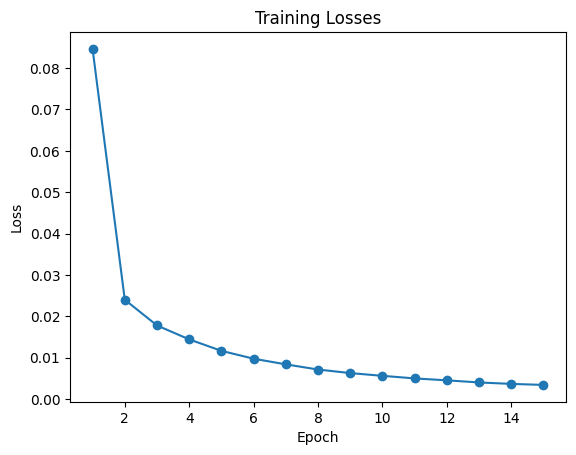

In [208]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Vérifiez si CUDA est disponible et définissez le périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fonction pour charger le modèle sauvegardé après une époque spécifique
def load_model(epoch):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model = model.to(device)
    checkpoint = torch.load(f'checkpoint_epoch_{epoch}.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

# Charger les pertes moyennes de l'entraînement
losses_df = pd.read_csv('training_losses.csv')
epochs = losses_df['epoch']
losses = losses_df['loss']

# Représenter graphiquement les pertes
plt.plot(epochs, losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.show()

# epoch 10

In [209]:
import numpy as np

def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth
    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print(err_male)
    print(err_female)
    return (err_male + err_female) / 2 + abs(err_male - err_female)

# 3. Faire des Prédictions avec les Modèles Chargés

In [214]:
# Charger le modèle pour l'époque 10
epoch = 10
model = load_model(epoch)

C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [215]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range), 'pred': float(y_pred[i]),
                             'target': float(y[i]), 'gender': float(gender[i])})

results_df = pd.DataFrame(results_list)

# Ajouter les colonnes 'true_range' et 'pred_range' au DataFrame
results_df['true_range'] = pd.cut(results_df['target'], bins=bins, labels=labels, include_lowest=True)
results_df['pred_range'] = pd.cut(results_df['pred'], bins=bins, labels=labels, include_lowest=True)

# Afficher les premières lignes du DataFrame pour vérifier les colonnes
print(results_df.head())

100%|██████████| 2534/2534 [02:10<00:00, 19.48it/s]

   true_range pred_range      pred  target  gender
0  0.05-0.075  0.075-0.1  0.099147   0.061   1.000
1    0.2-0.25  0.075-0.1  0.079161   0.213   0.845
2    0.15-0.2   0.1-0.15  0.112883   0.195   0.999
3     0-0.025    0-0.025  0.014588   0.015   0.999
4    0.1-0.15   0.1-0.15  0.105238   0.108   0.001


In [216]:
# Ajouter les colonnes 'true_range' et 'pred_range' au DataFrame
results_df['true_range'] = pd.cut(results_df['target'], bins=bins, labels=labels, include_lowest=True)
results_df['pred_range'] = pd.cut(results_df['pred'], bins=bins, labels=labels, include_lowest=True)

# Afficher les premières lignes du DataFrame pour vérifier les colonnes
print(results_df.head())

   true_range pred_range      pred  target  gender
0  0.05-0.075  0.075-0.1  0.099147   0.061   1.000
1    0.2-0.25  0.075-0.1  0.079161   0.213   0.845
2    0.15-0.2   0.1-0.15  0.112883   0.195   0.999
3     0-0.025    0-0.025  0.014588   0.015   0.999
4    0.1-0.15   0.1-0.15  0.105238   0.108   0.001


In [217]:
y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Epoch {epoch}')
plt.show()

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
# Afficher le rapport de classification
print(f"Classification Report for Epoch {epoch}:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


Results for epoch 10
       pred  target  gender
0  0.099147   0.061   1.000
1  0.079161   0.213   0.845
2  0.112883   0.195   0.999
3  0.014588   0.015   0.999
4  0.105238   0.108   0.001


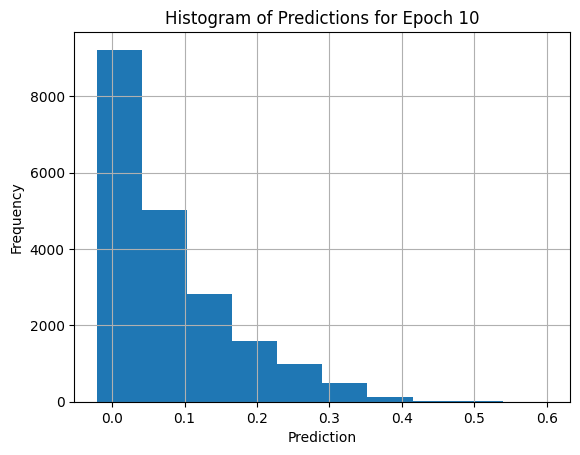


Results for epoch 11
       pred  target  gender
0  0.085994   0.061   1.000
1  0.030881   0.213   0.845
2  0.081858   0.195   0.999
3  0.016368   0.015   0.999
4  0.108633   0.108   0.001


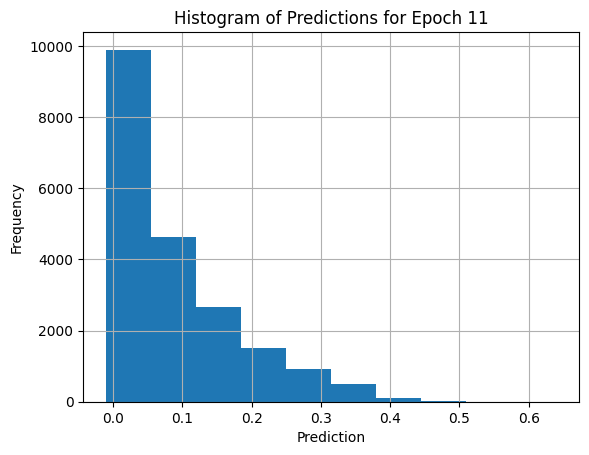

In [200]:
# Afficher les premières lignes de results_df et tracer l'histogramme des prédictions pour les deux époques
for epoch, results_df in results_dfs.items():
    print(f"\nResults for epoch {epoch}")
    print(results_df.head())
    results_df['pred'].hist()
    plt.title(f'Histogram of Predictions for Epoch {epoch}')
    plt.xlabel('Prediction')
    plt.ylabel('Frequency')
    plt.show()

In [207]:
# Charger les prédictions pour les époques 10 et 11
for epoch in [10, 11]:
    print(f"Loading predictions for epoch {epoch}")
    results_df = pd.read_csv(f'predictions_epoch_{epoch}.csv')
    
    y_true = results_df['target']  # Utilisez la colonne 'target' pour les valeurs réelles
    y_pred = results_df['pred']    # Utilisez la colonne 'pred' pour les valeurs prédites

    # Créer les ranges pour les valeurs réelles et prédites
    true_range = pd.cut(y_true, bins=bins, labels=labels, include_lowest=True)
    pred_range = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)

    cm = confusion_matrix(true_range, pred_range, labels=labels)

    # Afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for Epoch {epoch}')
    plt.show()

    # Afficher le rapport de classification
    print(f"Classification Report for Epoch {epoch}:\n")
    print(classification_report(true_range, pred_range, labels=labels, target_names=labels))

Loading predictions for epoch 10


TypeError: '<' not supported between instances of 'float' and 'str'

In [210]:
# Charger le modèle pour l'époque 10
epoch = 10
model = load_model(epoch)

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    for i in range(len(X)):
        results_list.append({'pred': float(y_pred[i]),
                              'target': float(y[i]),
                              'gender': float(gender[i])
                             })

results_df = pd.DataFrame(results_list)

# Afficher les premières lignes de results_df pour vérifier
print(results_df.head())

C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2534/2534 [01:20<00:00, 31.40it/s]

       pred  target  gender
0  0.099147   0.061   1.000
1  0.079161   0.213   0.845
2  0.112883   0.195   0.999
3  0.014588   0.015   0.999
4  0.105238   0.108   0.001


In [212]:
# Assurez-vous que les colonnes 'true_range' et 'pred_range' sont bien présentes
if 'true_range' not in results_df.columns or 'pred_range' not in results_df.columns:
    raise KeyError("Les colonnes 'true_range' et 'pred_range' doivent être présentes dans le DataFrame")

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Epoch {epoch}')
plt.show()

# Afficher le rapport de classification
print(f"Classification Report for Epoch {epoch}:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

KeyError: "Les colonnes 'true_range' et 'pred_range' doivent être présentes dans le DataFrame"

C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2534/2534 [02:02<00:00, 20.68it/s]


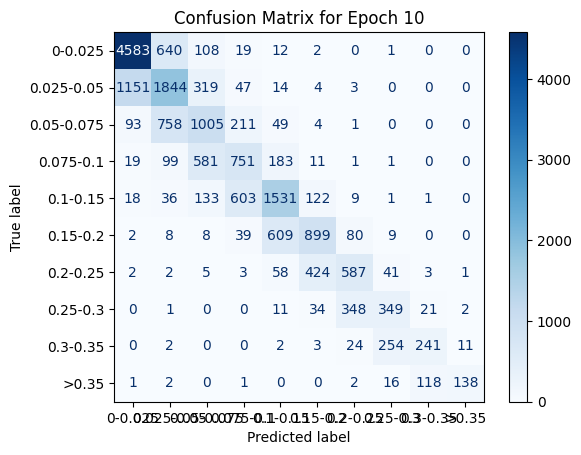

Classification Report for Epoch 10:

              precision    recall  f1-score   support

     0-0.025       0.78      0.73      0.75      6288
  0.025-0.05       0.54      0.54      0.54      3396
  0.05-0.075       0.47      0.47      0.47      2122
   0.075-0.1       0.45      0.46      0.45      1646
    0.1-0.15       0.62      0.62      0.62      2456
    0.15-0.2       0.60      0.54      0.57      1654
    0.2-0.25       0.56      0.52      0.54      1126
    0.25-0.3       0.52      0.46      0.49       766
    0.3-0.35       0.63      0.45      0.52       537
       >0.35       0.91      0.50      0.64       278

   micro avg       0.62      0.59      0.60     20269
   macro avg       0.61      0.53      0.56     20269
weighted avg       0.62      0.59      0.60     20269



In [218]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Charger le modèle pour l'époque 10
epoch = 10
model = load_model(epoch)

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range), 'pred': float(y_pred[i]),
                             'target': float(y[i]), 'gender': float(gender[i])})

results_df = pd.DataFrame(results_list)

# Calculer et afficher la matrice de confusion
y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Epoch {epoch}')
plt.show()

# Afficher le rapport de classification
print(f"Classification Report for Epoch {epoch}:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


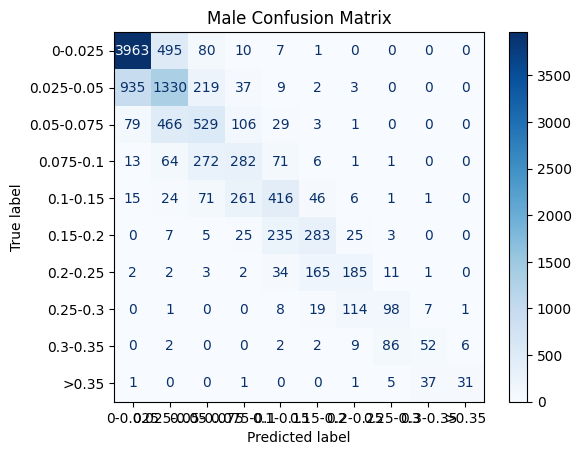

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.79      0.74      0.76      5384
  0.025-0.05       0.56      0.52      0.54      2549
  0.05-0.075       0.45      0.44      0.44      1214
   0.075-0.1       0.39      0.40      0.39       710
    0.1-0.15       0.51      0.49      0.50       843
    0.15-0.2       0.54      0.49      0.51       583
    0.2-0.25       0.54      0.46      0.49       405
    0.25-0.3       0.48      0.40      0.43       248
    0.3-0.35       0.53      0.33      0.40       159
       >0.35       0.82      0.41      0.54        76

   micro avg       0.63      0.59      0.61     12171
   macro avg       0.56      0.47      0.50     12171
weighted avg       0.63      0.59      0.61     12171



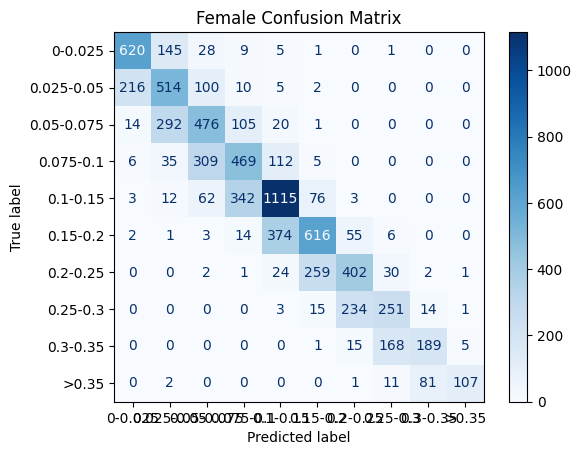

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.72      0.69      0.70       904
  0.025-0.05       0.51      0.61      0.56       847
  0.05-0.075       0.49      0.52      0.50       908
   0.075-0.1       0.49      0.50      0.50       936
    0.1-0.15       0.67      0.69      0.68      1613
    0.15-0.2       0.63      0.58      0.60      1071
    0.2-0.25       0.57      0.56      0.56       721
    0.25-0.3       0.54      0.48      0.51       518
    0.3-0.35       0.66      0.50      0.57       378
       >0.35       0.94      0.53      0.68       202

   micro avg       0.59      0.59      0.59      8098
   macro avg       0.62      0.57      0.59      8098
weighted avg       0.60      0.59      0.59      8098



In [219]:
# Séparer les résultats par sexe
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]

# Fonction pour afficher la matrice de confusion et le rapport de classification pour chaque sexe
def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

# Afficher les matrices de confusion et les rapports de classification par sexe
plot_confusion_matrix(results_male, "Male Confusion Matrix")
plot_confusion_matrix(results_female, "Female Confusion Matrix")

In [220]:
metric_fn(results_male, results_female)

0.001311406528622241
0.0011296149844794874


0.0014023023006936178

In [221]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)


test_df.head()

100%|██████████| 3814/3814 [02:14<00:00, 28.41it/s]


,pred
0,0.382016
1,0.370009
2,0.430629
3,0.296200
4,0.414545


In [222]:
test_df.to_csv("Data_Challenge_4.csv", header = None, index = None)